In [1]:
import librosa

# Load './dummy.wav'
data, sr = librosa.load('./dummy.wav', sr=16000)
print(data.shape, sr)

(306875,) 16000


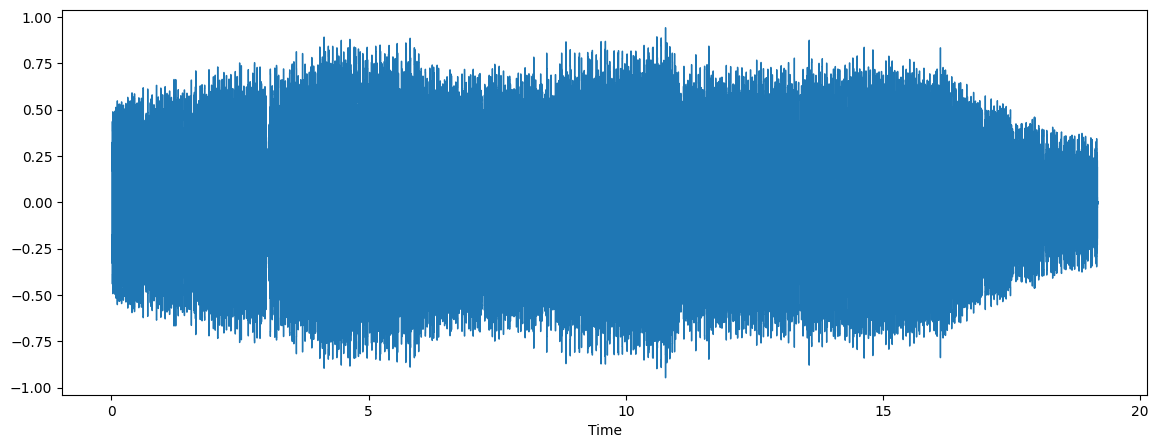

In [2]:
import matplotlib.pyplot as plt
import librosa.display

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(data, sr=sr)

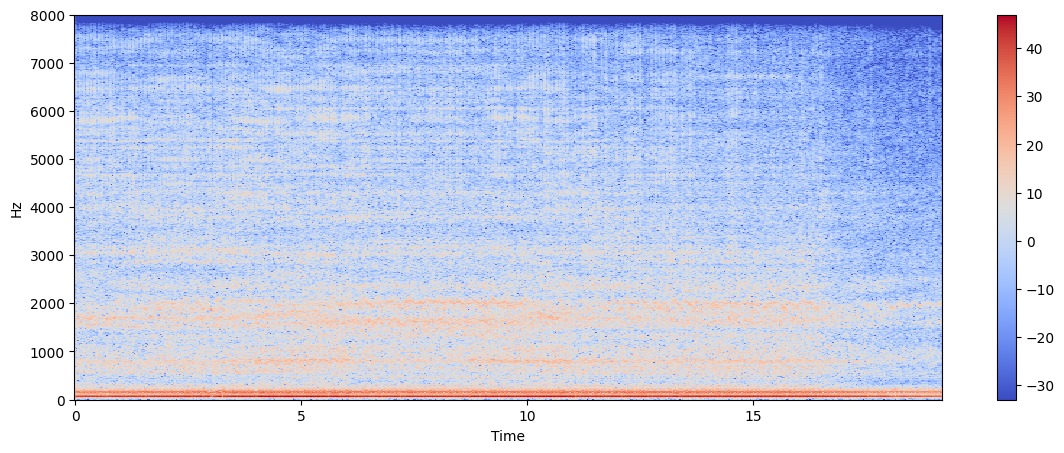

In [3]:
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))

# Plot the spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()


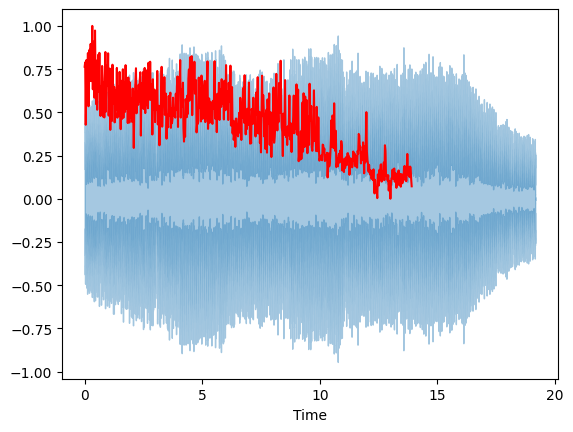

In [11]:
# Feature Analysis, MFCC, e.g. Spectral Centroid
import sklearn
from sklearn import preprocessing
spectral_centroids = librosa.feature.spectral_centroid(y=data, sr=sr)[0]
spectral_centroids.shape

# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return preprocessing.minmax_scale(x, axis=axis)

# Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(data, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')
